In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg

%matplotlib widget

In [2]:
# function [R t, a] = gPPnP(P,O,S,tol,pz)
# from A. Fusiello, F. Crosilla, and F. Malapelle, “Procrustean point-line 
# registration and the NPnP problem,” in 2015 International Conference on 
# 3D Vision, Oct. 2015, pp. 250–255. doi: 10.1109/3DV.2015.35.
def gPPnP(P, O, S, tol, pz = True, unit_scale=True):
    """
    input
        P : matrix (nx3) of line versors
        O : matrix (nx3) of line origins
        S : matrix (nx3) 3D coordinates
        tol: exit tolerance
        pZ : positive Z flag
        unit_scale : whether or not to compute the scale factor
    output
        T: Euclidean transform from frame of P and O to frame of S
        iter: number of iterations to reach tolernce
    """
    n = P.shape[0]
    #print(P.shape, O.shape, S.shape)
    Z = np.diag(np.ones(n)) #Z is n x n
    II = np.identity(n) - np.full((n,n), 1.0/n) # II is n x n
    err = np.inf
    E_old = 1000 * np.ones((n, 3))   # E_old is n x 3
    D = linalg.khatri_rao(np.identity(n), P.T)   # D is 3n x n
    iter = 0
    while err > tol:
        iter += 1
        U, _, Vt = np.linalg.svd((Z @ P + O).T @ II @ S)  # (Z @ P + O).T @ II @ S is 3 x 3, U and Vt are 3 x 3
        R = U @ np.diag([1, 1, np.linalg.det(U @ Vt)]) @ Vt  # R is 3 x 3
        A = Z @ P + O    # A is n x 3
        AR = A @ R  # AR is n x 3
        if unit_scale:
            a = 1
        else:
            a = np.trace(A.T @ II @ A) / np.trace(AR.T @ II @ S)  # A.T @ II @ A is 3 x 3, AR.T @ II @ S is 3 x 3
        
        c = np.mean(a * S - AR, axis = 0, keepdims=True).T # c is 3 x 1
        X = a * S - O @ R - np.ones((n,1)) @ c.T      # X is n x 3
        vecY = (R @ X.T).reshape((-1,1), order="F")   # R @ X.T is 3 x n, vecY is 3n x 1
        v, _, _, _ = np.linalg.lstsq(D, vecY, rcond=None) # v is n by 1
        if pz:
            v[v<0] = 0

        # print("v shape is ", v.shape)
        Z = np.diag(v.reshape(-1)) # Z is n x n
        E = X - Z @ P @ R        # E is n x 3
        err = np.linalg.norm(E - E_old)
        E_old = E

    t = -R @ c
    
    return np.vstack((np.hstack((R.T, -R.T @ t)),
                      np.array([0,0,0,1]))), iter, err



   # function [R t, a] = gFiore(P,O,S)
def gFiore(P,O,S, unit_scale=True):
    """
    input
        P : matrix (nx3) of line versors
        O : matrix (nx3) of line origins
        S : matrix (nx3) 3D coordinates
        unit_scale : whether or not to compute the scale factor
    output
        T: Euclidean transform from frame of P and O to frame of S
    """
    n = P.shape[0]
    II = np.identity(n) - np.full((n,n), 1.0/n)
    M = np.concatenate((S, np.ones((n,1))), axis=1).T
    _, sv, Vt = np.linalg.svd(M)
    tol = sv.max() * max(M.shape) * np.finfo(M.dtype).eps
    rankM = (sv > tol).sum()
    # print("rank M is ", rankM)
    Vrt = Vt[rankM:,:]
    # print("shape of Vrt is ", Vrt.shape)
    D = (P @ P.T) * (Vrt.T @ Vrt)
    # print("D is ", D)
    b = -np.diag((Vrt.T @ Vrt @ O @ P.T))
    # print("b is ", b)
    v, _, _, _ = np.linalg.lstsq(D, b, rcond=None)
    # print("v is ", v)
    Z = np.diag(v.reshape(-1))
    U, _, Vt = np.linalg.svd((Z @ P + O).T @ II @ S)
    R = U @ np.diag([1, 1, np.linalg.det(U @ Vt)]) @ Vt
    A = Z @ P + O 
    AR = A @ R
    if unit_scale:
        a = 1 
    else:
        a = np.trace(A.T @ II @ A) / np.trace(AR.T @ II @ S)

    c = np.mean(a * S - AR, axis = 0, keepdims=True).T
    t = -R @ c
    
    return np.vstack((np.hstack((R.T, -R.T @ t)),
                      np.array([0,0,0,1])))


In [3]:
# test code

# Create ground truth tag locations, general camera locations, and real 
# camera 0-3 locations
%run ../simulate/simulate_cam.ipynb
    
# test gPNP functions
A_s = A[:, 3::5]
print(A_s.shape)
print("Ground truth T is\n", np.round(T[4,:,:], 3))
P,O,_ = project(T[4,:,:], A_s, CT)
print("P is ", np.round(P, 3))
print("O is ", np.round(O, 3))
T_i, itr, err = gPPnP(P, O, A_s[0:3,:].T, tol=0.000001*np.prod(A_s.shape))
print("T_i is\n", np.round(T_i, 3))
print("gPPnP used ", itr, " iterations and resulted in RMS error = ", err/np.sqrt(np.prod(A_s.shape)))
T_s = gFiore(P, O, A_s[0:3,:].T)
print("T_s is\n", np.round(T_s, 3))


[[-0.02471586 -0.14829514  0.98863425]] [-0.02939905  0.99956775  0.        ]
[[-0.34778931  0.18701112  0.91873252]] [0.48782136 0.87294348 0.        ]
[[-0.53878763  0.4099979   0.73594131]] [0.75377273 0.6571352  0.        ]
[[-0.62597629  0.52507376  0.57658584]] [0.86642996 0.49929862 0.        ]
[[-0.66601916  0.5850351   0.46276604]] [0.91854256 0.39532211 0.        ]
[[-0.3202944  -0.42605703  0.846101  ]] [-0.02534286  0.86165738  0.50685728]
[[-0.58644024 -0.12015465  0.80103102]] [0.43395285 0.7765472  0.45679247]
[[-0.7286323   0.13661326  0.67114215]] [0.70307371 0.61293606 0.36055062]
[[-0.78263176  0.3029498   0.54379127]] [0.8313158  0.47906334 0.28180197]
[[-0.79829935  0.40550693  0.44528897]] [0.89467093 0.38504825 0.22649897]
[[-0.01246402 -0.07478414  0.99712185]] [ 0.01351228 -0.9999087   0.        ]
[[-0.15732124 -0.24111649  0.9576601 ]] [ 0.24869025 -0.96858307  0.        ]
[[-0.29912644 -0.37586974  0.87706631]] [ 0.46623908 -0.88465876  0.        ]
[[-0.40502

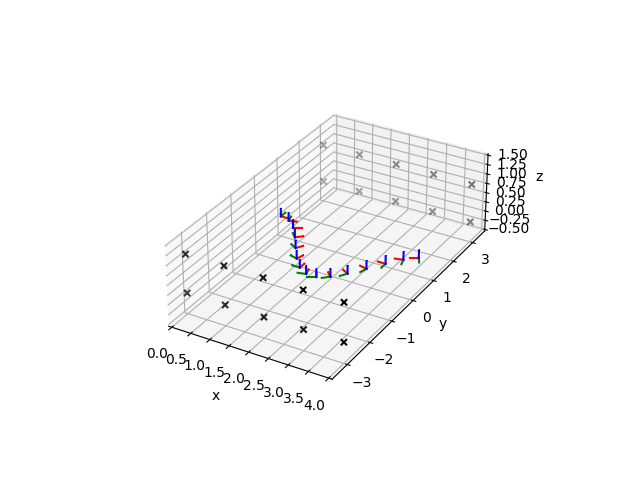

In [4]:
# function to plot a coordinate frame axis in red-green-blue (for x, y, z)
def coordframe(ax, T):
    """
       Parameters:
           ax: axes to plot on
           T:  3x4 or 4x4 matrix giving the homogeneous transform from the coordinate 
               frame to be plotted to the world frame. Note that the scale of the axes
               can be captured in T.
    """
    ax.plot3D([T[0,3], T[0,3]+T[0,0]], [T[1,3], T[1,3]+T[1,0]], [T[2,3], T[2,3]+T[2,0]], ',-r')
    ax.plot3D([T[0,3], T[0,3]+T[0,1]], [T[1,3], T[1,3]+T[1,1]], [T[2,3], T[2,3]+T[2,1]], ',-g')
    ax.plot3D([T[0,3], T[0,3]+T[0,2]], [T[1,3], T[1,3]+T[1,2]], [T[2,3], T[2,3]+T[2,2]], ',-b')
    
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d', aspect='equal', xlabel='x', ylabel='y', zlabel='z')

# plot coordinate frames for the general camera locations
for cf in T:
    s = 0.2
    coordframe(ax, cf @ np.diag([s,s,s,1]))
    
# plot the tag locations
ax.scatter(A[0,:], A[1,:], A[2,:], c='k', marker='x')

ax.set_xlim([0, 4])
ax.set_ylim([-3.5, 3.5])
ax.set_zlim([-0.5, 1.5])
ax.set_aspect('equal')

plt.show()